<a href="https://colab.research.google.com/github/srvmishra/Language-Models/blob/main/KDE4_Dataset_Translation_English_to_Hindi_with_opus_mt_en_hi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate
!pip install sacrebleu

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

from huggingface_hub import notebook_login

### Load Dataset for English to Hindi Translation

In [3]:
translation_data = load_dataset('kde4', lang1='en', lang2='hi')
translation_data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 97227
    })
})

### Inspect Dataset

Get an estimate of the `max_length` by looking at the lengths of the source and target language texts.

In [4]:
def view_samples_and_lengths(example):
  src_lang_text = [text['en'] for text in example['translation']]
  tgt_lang_text = [text['hi'] for text in example['translation']]
  print('English: ', src_lang_text)
  print('Hindi: ', tgt_lang_text)
  print('English: ', [len(src.split()) for src in src_lang_text])
  print('Hindi: ', [len(tgt.split()) for tgt in tgt_lang_text])
  return

In [5]:
samples = translation_data['train'].select(range(5))
samples['translation']

[{'en': 'Add Feed to Akregator', 'hi': 'फ़ीड को एकेरेगेटर में जोड़ें'},
 {'en': 'Add Feeds to Akregator', 'hi': 'फ़ीडों को एकेरेगेटर में जोड़ें'},
 {'en': 'Add All Found Feeds to Akregator',
  'hi': 'सभी प्राप्त फ़ीडों को एकेरेगेटर में जोड़ें'},
 {'en': 'Subscribe to site updates (using news feed)',
  'hi': 'साइट अपडेट की ग्राहकी लें (समाचार फ़ीडों के जरिए)'},
 {'en': 'Imported Feeds', 'hi': 'आयातित फ़ीड'}]

In [6]:
view_samples_and_lengths(samples)

English:  ['Add Feed to Akregator', 'Add Feeds to Akregator', 'Add All Found Feeds to Akregator', 'Subscribe to site updates (using news feed)', 'Imported Feeds']
Hindi:  ['फ़ीड को एकेरेगेटर में जोड़ें', 'फ़ीडों को एकेरेगेटर में जोड़ें', 'सभी प्राप्त फ़ीडों को एकेरेगेटर में जोड़ें', 'साइट अपडेट की ग्राहकी लें (समाचार फ़ीडों के जरिए)', 'आयातित फ़ीड']
English:  [4, 4, 6, 7, 2]
Hindi:  [5, 5, 7, 9, 2]


In [7]:
def add_lengths_to_dataset(example):
  src_lang_len = [len(text['en'].split()) for text in example['translation']]
  tgt_lang_len = [len(text['hi'].split()) for text in example['translation']]
  example['src_lang'] = [text['en'] for text in example['translation']]
  example['tgt_lang'] = [text['hi'] for text in example['translation']]
  example['src_lang_len'] = src_lang_len
  example['tgt_lang_len'] = tgt_lang_len
  return example

In [8]:
processed_dataset = translation_data.map(add_lengths_to_dataset, batched=True,
                                         remove_columns=translation_data['train'].column_names)
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['src_lang', 'tgt_lang', 'src_lang_len', 'tgt_lang_len'],
        num_rows: 97227
    })
})

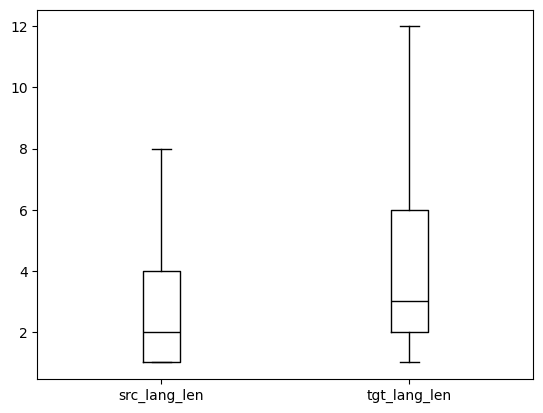

In [9]:
processed_dataset.set_format('pandas', columns=['src_lang_len', 'tgt_lang_len'])
processed_df = processed_dataset['train'][:]

processed_df.boxplot(['src_lang_len', 'tgt_lang_len'], showfliers=False, grid=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

processed_dataset.reset_format()

### Train Test Split

In [10]:
processed_dataset = processed_dataset['train'].train_test_split(train_size=0.9, seed=42)
processed_dataset['validation'] = processed_dataset.pop('test')
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['src_lang', 'tgt_lang', 'src_lang_len', 'tgt_lang_len'],
        num_rows: 87504
    })
    validation: Dataset({
        features: ['src_lang', 'tgt_lang', 'src_lang_len', 'tgt_lang_len'],
        num_rows: 9723
    })
})

KDE4 en-fr data feature: Some technical words are translated into the target language in the dataset but the pretrained model does not translate these words because it works that way in normal day to day conversations. Similar thing is seen in en-hi. Original non-translatable words are retained in the source language, in the dataset as well.

### Load Model and Tokenizer

Check translation on an example piece of text.

Model: `Helsinki-NLP/opus-mt-en-hi`

In [11]:
model_ckpt = 'Helsinki-NLP/opus-mt-en-hi'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
translator = pipeline('translation', model=model_ckpt)
translator('Hello, How are you doing today?')

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


[{'translation_text': 'हैलो, आप आज कैसे कर रहे हैं?'}]

### Tokenize Dataset

Since most texts are of small length, we keep the `max_length` parameter to 128.

In [12]:
def translator_tokenize(examples):
  return tokenizer(examples['src_lang'], text_target=examples['tgt_lang'],
                   truncation=True, max_length=20)

In [13]:
processsed_dataset_tokenized = processed_dataset.map(translator_tokenize, batched=True,
                                                     remove_columns=processed_dataset['train'].column_names)

Map:   0%|          | 0/87504 [00:00<?, ? examples/s]

Map:   0%|          | 0/9723 [00:00<?, ? examples/s]

In [14]:
processsed_dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 87504
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9723
    })
})

Data Collation:

1. Padding tokens are replaced by -100 after tokenization as these indices are ignored in the calculation of cross entropy loss.
2. This is handled by the `DataCollatorForSeq2Seq`. We need both the `inputs` and the `labels` to be padded with -100 till the `max_length` in the batch (dynamic padding). `DataCollatorWithPadding` only does this on the `inputs`.
3. `DataCollatorForSeq2Seq` takes the tokenizer as well as the model.
4. It adds a new field to the batch: `decoder_input_ids` which are shifted version of `labels` with a special token added at the beginning. This special token is also assigned to the padding tokens present in the input side. So all -100s in the tokenized input are mapped to this special token on the target language side.
5. This special token differs from one model architecture to another, so the model object is needed inside the `DataCollatorForSeq2Seq`.
6. `decoder_input_ids` are created from the target language input ids or `labels` by shifting them. These are only available during training, not during inference.

In [15]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [16]:
samples = processsed_dataset_tokenized['train'].shuffle(42).select(range(5))
print('Before collator: ', samples.features.keys()) # --> note that this is a slice of the dataset, so we have to use features to get keys
# because dataset.features is a dictionary object
batch = data_collator(samples) # --> this simply returns a dictionary so we can directly access the keys
print('After collator: ', batch.keys())
print('Labels: ', batch['labels'])
print('Decoder IDs: ', batch['decoder_input_ids'])

Before collator:  dict_keys(['input_ids', 'attention_mask', 'labels'])
After collator:  dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
Labels:  tensor([[ 2972,     0,  -100,  -100,  -100,  -100,  -100,  -100],
        [ 1174,  1622,  1498,    12,   587,   690,     0,  -100],
        [13564,  1787,     0,  -100,  -100,  -100,  -100,  -100],
        [ 7169,    24,  1103,  8153,   667,  6635, 17450,     0],
        [ 8004, 11325,     0,  -100,  -100,  -100,  -100,  -100]])
Decoder IDs:  tensor([[61949,  2972,     0, 61949, 61949, 61949, 61949, 61949],
        [61949,  1174,  1622,  1498,    12,   587,   690,     0],
        [61949, 13564,  1787,     0, 61949, 61949, 61949, 61949],
        [61949,  7169,    24,  1103,  8153,   667,  6635, 17450],
        [61949,  8004, 11325,     0, 61949, 61949, 61949, 61949]])


### Compute Metrics for Translation

BLEU score
1. Evaluation in Seq2Seq uses BLEU score.
2. It is a statistical score, and does not account for grammatical correctness or intelligence.
3. This expects the inputs and outputs to be tokenizer, so it is heavliy dependent on the tokenizer and the model.
4. To standardize this tokenization process for comparing the performance of different models, we use `SacreBLEU`.

Input: predictions --> list of sentences; references --> list of list of sentences

Because there can be multiple translations for the same source sentence.

In [17]:
metrics = evaluate.load('sacrebleu')

def compute_metrics(eval_preds):
  preds, labels = eval_preds

  # this check is important for different model types
  if isinstance(preds, tuple):
    preds = preds[0]

  # we dont want padding tokens to mess up the scores
  predictions = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  references = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # post process: what does .strip() do?
  predictions = [pred.strip() for pred in predictions] # --> list
  references = [[ref.strip()] for ref in references] # --> list of lists

  # compute the metrics
  results = metrics.compute(predictions=predictions, references=references)
  return {'bleu': results['score'], 'penalty': results['bp']}

### Finetune the Model

Seq2SeqTrainer
1. Seq2Seq tasks involve Autoregressive text generation unlike language understanding tasks such as classification.
2. So, we need to be able to use the generate method of the models inside the evaluation.
3. This is handled by the `Seq2SeqTrainer`. We use `predict_with_generate=True` in `Seq2SeqTrainingArguments`.

In [ ]:
notebook_login()

In [19]:
train_batch_size = 32
eval_batch_size = 64
logging_steps = len(processsed_dataset_tokenized['train'])//train_batch_size
model_name = f'srvmishra832/KDE4-EN2HI-{model_ckpt}'
training_arguments = Seq2SeqTrainingArguments(output_dir=model_name,
                                              num_train_epochs=3, log_level='error', disable_tqdm=False,
                                              per_device_train_batch_size=train_batch_size,
                                              per_device_eval_batch_size=eval_batch_size,
                                              logging_steps=logging_steps, save_strategy='epoch',
                                              evaluation_strategy='no', learning_rate=2e-5,
                                              weight_decay=0.01, predict_with_generate=True,
                                              fp16=True, push_to_hub=True, save_total_limit=3)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer = Seq2SeqTrainer(model=model, args=training_arguments,
                         train_dataset=processsed_dataset_tokenized['train'],
                         eval_dataset=processsed_dataset_tokenized['validation'],
                         tokenizer=tokenizer, data_collator=data_collator,
                         compute_metrics=compute_metrics)

<ipython-input-20-2d015b3d4f63>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(model=model, args=training_arguments,


In [21]:
trainer.evaluate(max_length=20)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: srvmishra832 (srvmishra832-indian-institute-of-science-bangalore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 2.119575023651123,
 'eval_model_preparation_time': 0.0049,
 'eval_bleu': 59.886508891144366,
 'eval_penalty': 0.9253908552810646,
 'eval_runtime': 117.041,
 'eval_samples_per_second': 83.073,
 'eval_steps_per_second': 1.299}

In [22]:
trainer.train()
trainer.push_to_hub()

Step,Training Loss
2734,1.331900
5468,1.056800
8202,0.956000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/srvmishra832/opus-mt-en-hi/commit/0aec3500ff3a25e2b1d8e3940b7c61a07edf64f5', commit_message='End of training', commit_description='', oid='0aec3500ff3a25e2b1d8e3940b7c61a07edf64f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srvmishra832/opus-mt-en-hi', endpoint='https://huggingface.co', repo_type='model', repo_id='srvmishra832/opus-mt-en-hi'), pr_revision=None, pr_num=None)

In [23]:
trainer.evaluate(max_length=20)

{'eval_loss': 0.9642634391784668,
 'eval_model_preparation_time': 0.0049,
 'eval_bleu': 54.98374943358887,
 'eval_penalty': 1.0,
 'eval_runtime': 112.1949,
 'eval_samples_per_second': 86.662,
 'eval_steps_per_second': 1.355,
 'epoch': 3.0}

The BLEU score decreases after finetuning even when the testing loss has decreased:
1. Maybe `max_length` needs to be shortened as sentences are too short.
2. Is `batch_size` important?
3. Overconfident translations? Repeating the same word over and over? Or too long sentences?

I think `max_length` needs to be shortened.

before training: 57~60 (does not vary much with max_length because model is not yet finetuned)

max_length = 128: after training: 29.02

max_length = 50: after training: 47.33

max_length = 20: after training: 54.98 \\

More tasks to explore:
1. T5 model translation and multi lingual model translation
3. multi lingual tokenizer settings for source and target languages
4. repeat for english to german translation too

Files: translation data loading utils and compute metrics utils depending on model and tokenizer in the above list.